## Double Pendulum

$T = \frac{1}{2} (m_1+m_2)L_1^2 \dot{\phi_1}^2 + m_2 L_1 L_2 \dot{\phi_1}\dot{\phi_2} \cos{(\phi_1 - \phi_2)} + \frac{1}{2}m_2 L_2^2 \dot{\phi_2}^2 $

$U = (m_1 + m_2)g L_1 (1-\cos{\phi_1}) + m_2 g L_2 (1-\cos{\phi_2})$

In [12]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [31]:

class DoublePendulum():
    """
    Pendulum class implements the parameters and differential equation for 
     a double pendulum using the notation above.
     
    Parameters
    ----------
    L1 : float
         first segment's length 
    L2 : float
        second segment's length
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    """
    def __init__(self, L1=1., L2=1, m1=1., m2=1., g=1.):
        self.L1=L1
        self.L2=L2
        self.m1=m1
        self.m2=m2
        self.g=g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi_1(t) 
            y[1] = dphi_1/dt
            y[2] = phi_2(t) 
            y[3] = dphi_2/dt
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dphi_1/dt
            y_dot[1] = d^2 phi_1/dt^2
            y_dot[2] = dphi_2/dt
            y_dot[3] = d^2 phi_2/dt^2       
        
        """
        y_dot = [0.,0.,0.,0.]
        
        # Do dphi_1/dt and dphi_2/dt first:
        y_dot[0] = y[1]
        y_dot[2] = y[3]
        
        # Now do d^2 phi_1/dt^2 
        y_dot[1] = -self.g*(2.*self.m1+self.m2)*np.sin(y[0])+self.m2* \
            (self.g*np.sin(y[0]-2*y[2])+2*(self.L2*(y[3]**2)+self.L1*( \
            y[1]**2)*np.cos(y[0]-y[2]))*np.sin(y[0]-y[2]))
        y_dot[1] /= 2*self.L1*(self.m1+self.m2-self.m2*(np.cos(y[0]-y[2])**2))
        
        # Finally do d^2 phi_2/dt^2 
        y_dot[3] = (self.L1*(self.m1+self.m2)*(y[1]**2)+self.g*(self.m1+ \
            self.m2)*np.cos(y[0])+self.L2*self.m2*(y[3]**2)*np.cos(y[0]-y[2])) \
            *np.sin(y[0]-y[2])
        y_dot[3] /= self.L2*(self.m1+self.m2-self.m2*(np.cos(y[0]-y[2])**2))
                    
        return y_dot
    
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot
                    
                    


In [32]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [96]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 20.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Common pendulum parameters
m_1 = 1.
m_2 = 0.1
L_1 = 1.
L_2 = 1.
g_ = 1.


# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L_1, L2=L_2, m1=m_1, m2=m_2, g=g_)

(2002,) (2002,) (2002,)
(2002,) (2002,)


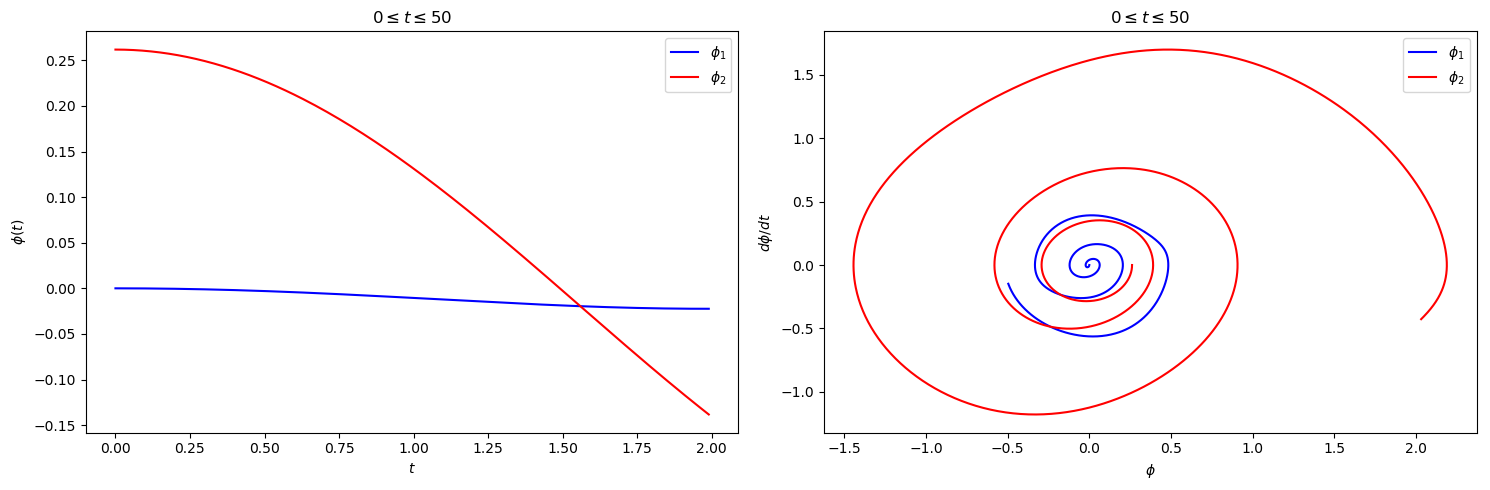

In [97]:
# both plots: same initial conditions
phi1_0     = 0
phi1_dot_0 = 0.
phi2_0     = np.pi/12.
phi2_dot_0 = 0.

phi1, phi1_dot, phi2, phi2_dot = dp1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

print(t_pts.shape, phi1.shape, phi2.shape)
print(phi1_dot.shape, phi2_dot.shape)

# start the plot!
fig = plt.figure(figsize=(15,5))
'''
overall_title = 'Double Pendulum:  ' + \
                rf' $m1 = {m1:.2f},$' + \
                rf' $m2 = {m2:.2f},$' + \
                rf' $L1 = {L1:.2f},$' + \
                rf' $L2 = {L2:.2f},$' + \
                rf' $g = {g:.2f},$' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\phi_1_dot(0) = {phi1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\phi_2_dot(0) = {phi2_dot_0:.2f},$' +\
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
'''
# first plot: plot from t=0 to t=10   
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 2.)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r"$\phi_1$", 
            title=r'$0 \leq t \leq 50$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r"$\phi_2$", 
            title=r'$0 \leq t \leq 50$', 
            ax=ax_a)  
'''                              
# second plot: plot from t=40 to t=50   
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, 40., 50.)    
plot_y_vs_x(t_pts[start : stop], phi[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title='(b)', 
            ax=ax_b)    
'''
# third plot: state space plot from t=30 to t=50   
ax_c = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 50.)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=r"$\phi_1$", 
            title=r'$0 \leq t \leq 50$', 
            ax=ax_c)    
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='red',
            label=r"$\phi_2$", 
            title=r'$0 \leq t \leq 50$', 
            ax=ax_c)   

fig.tight_layout()
fig.savefig('DoublePend.png', bbox_inches='tight')  # always bbox_inches='tight'